# Chapter 08 차원 축소

In [ ]:
# 글꼴 다운
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 3s (3,395 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

In [ ]:
# 기본설정

# 파이썬 버전 확인
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 버전 확인
import sklearn
assert sklearn.__version__ >= "0.20"

# 공동 모듈 임포트
import numpy as np
import os

# 그래프 출력 설정
%matplotlib inline
# 위에꺼는 구버전에서 설정해야 되는거였음 설정안해도됨
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 한글출력
mpl.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False  # 그래프에서 마이너스 기호 표시되도록

# 그림 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ho_chap_08"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)   # exist_ok=True 폴더가 없으면 생성

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()  # 입력없이 사용할 경우 기존에 세팅된 기본값으로 자동 레이아웃 설정
    plt.savefig(path, format=fig_extension, dpi=resolution)  # dpi값 설정을 통해 고해상도 그래프 그리기 가능

밑에서 활용할 3D 데이터셋 만들기

In [ ]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

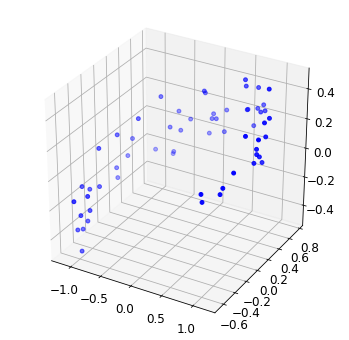

In [ ]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], c="b", marker="o", s=15, cmap="Greens")
plt.show()

## 8.3 PCA

### 8.3.2 주성분
* 사이킷런이 아닐땐 항상 데이터를 원점에 맞춰주는걸 잊으면 안됨

In [ ]:
# 단위 벡터 추출
from numpy import linalg as LA

X_centered = X - X.mean(axis=0)  # 사이킷런은 자동으로 평균 0으로 맞춰줌
U, s, Vt = LA.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

### 8.3.3 d차원으로 투영하기

In [ ]:
# 두개의 주성분으로 정의된 평면에 훈련 세트를 투영
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)
X2D.shape

(60, 2)

### 8.3.4 사이킷런 사용하기

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)
X2D.shape

(60, 2)

### 8.3.5 설명된 분산의 비율
* 각 주성분의 축을 따라 있는 데이터셋의 분산 비율

In [ ]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

데이터셋 분산의 84.2%가 첫 번째 PC를 따라 놓여 있고 14.6%가 두 번째 PC를 따라 놓여 있음을 알 수 있음.

### 8.3.6 적절한 차원 수 선택하기
* 일반적으로 충분한 분산(ex 95%)이 될 때까지 더해야 할 차원 수를 선택
* 데이터 시각화를 위해 차원을 축소할 시에는 2,3차원으로 줄임
* n_components를 지정하지 않으면 특성 숭와 샘플 수 중 작은 값으로 설정

In [ ]:
# 차원을 축소하지 않고 PCA 계산 후 훈련 세트의 분산을 95%로 유지하는데
# 필요한 최소한의 차원 수를 계산

pca = PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
print(cumsum)
d = np.argmax(cumsum >= 0.95) + 1  # argmax는 큰 애들 중 첫번째 인덱스를 반환


[0.84248607 0.98880446 1.        ]


n_components=d로 설정할 수도 있지만 보존하려는 분산의 이율을 0.0~1.0 사이로 설정하는게 훨씬 나음

In [ ]:
# mnist 셋 가져오기
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

그래프로 보면 꺾이는 지점 있음

In [ ]:
pca_m = PCA()
X_m = pca_m.fit_transform(X_train)

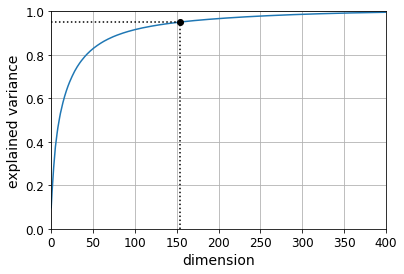

In [ ]:
cumsum_m = np.cumsum(pca_m.explained_variance_ratio_)
plt.plot(cumsum_m)
plt.plot()
plt.axis([0, 400, 0, 1])
plt.plot([154, 154], [0, 0.95], "k:")
plt.plot([0, 154], [0.95, 0.95], "k:")
plt.plot(154, 0.95, "ko")
plt.xlabel('dimension')
plt.ylabel('explained variance')
plt.grid()
plt.show()

### 8.3.7 압축을 위한 PCA
* 원본 데이터와 재구성된 데이터 사이의 MSE를 재구성 오차라고 함

In [ ]:
# 압축 후 복원
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)
X_recovered.shape

(52500, 784)

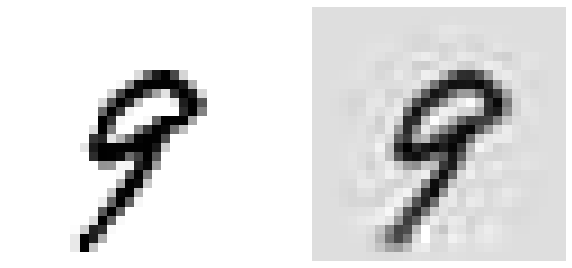

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(X_train[0].reshape(28, 28), cmap="gray_r")
axs[1].imshow(X_recovered[0].reshape(28, 28), cmap="gray_r")
axs[0].axis("off")
axs[1].axis("off")
plt.show()

### 8.3.8 랜덤 PCA
* svd_solver 매개변수를 "randomized"로 지정하면 처음 d개의 주성분에 대한 근삿값을 빠르게 찾는다.
* d가 n보다 많이 작으면 완전 SVD보다 훨씬 빠름

In [ ]:
rnd_pca = PCA(n_components=154, svd_solver="randomized") # svd_solver의 기본 값은 'auto'
X_reduced = rnd_pca.fit_transform(X_train)

### 8.3.9 점진적 PCA (IPCA)
* PCA 구현에서는 SVD 알고리즘 실행 위해 전체 훈련 세트를 메모리에 올려야 함.
* 점진적 PCA는 훈련 세트를 미니배치로 나눈 뒤 IPCA 알고리즘에 한 번에 하나씩 주입

In [ ]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

넘파이의 memmap을 사용하면 하드 디스크의 이진 파일에 저장된 매우 큰 배열을 메모리에 들어 있는 것처럼 다루기 가능.<br/>
밑의 코드처럼 이 방식을 적용하면 일반적인 fit() 메서드 사용 가능.<br/>

In [ ]:
filename = "my_mnist.data"
m, n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train

In [ ]:
del X_mm

In [ ]:
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, copy=True, n_components=154, whiten=False)

## 8.4 커널 PCA

In [ ]:
from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [ ]:
# rbf 커널
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components= 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

linear, rbf, sigmoid 그래프로 확인

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


그림 저장: kernel_pca_plot


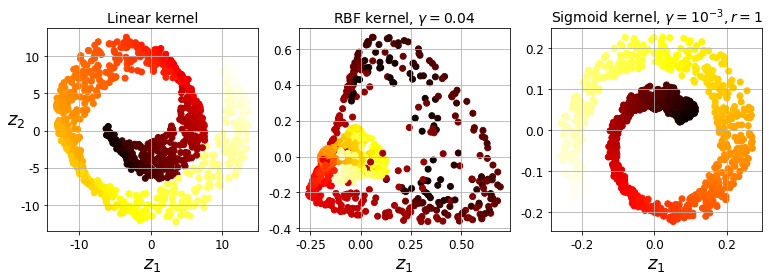

In [ ]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components=2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components=2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

save_fig("kernel_pca_plot")
plt.show()

### 8.4.1 커널 선택과 하이퍼파라미터 튜닝
* kPCA는 비지도 학습이라 커널과 하이퍼파라미터를 선택하기 위한 명확한 성능 측정 기준이 없음.
* But 차원축소는 지도학습의 전처리 단계로 자주 활용되므로 그리드 탐색을 통해 찾을 수 있음.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
                ("kpca", KernelPCA(n_components=2)),
                ("log_reg", LogisticRegression())
                ])

param_grid = [{
                "kpca__gamma": np.linspace(0.03, 0.05, 10),     # __ 가 내부로 진입하는 변수같음, 기본도 진행되나?
                "kpca__kernel": ["rbf", "sigmoid"]
            }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('kpca',
                                        KernelPCA(alpha=1.0, coef0=1,
                                                  copy_X=True, degree=3,
                                                  eigen_solver='auto',
                                                  fit_inverse_transform=False,
                                                  gamma=None, kernel='linear',
                                                  kernel_params=None,
                                                  max_iter=None, n_components=2,
                                                  n_jobs=None,
                                                  random_state=None,
                                                  remove_zero_eig=False,
                                                  tol=0)),
                                       ('log_reg',
                                 

In [ ]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


커널을 사용한 pca는 재구성이 쉽지않음.<br/>
한가지 방법으로 투영된 샘플을 훈련세트로, 원본 샘플을 타깃으로 하는 지도 학습 회귀 모델을 활용하면 재구성 가능

In [ ]:
rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [ ]:
# 재구성 원상 오차 계산
from sklearn.metrics import mean_squared_error
mean_squared_error(X, X_preimage)

32.786308795766125

이렇게 하면 재구성 원상 오차를 최소화하는 커널과 하이퍼파라미터를 찾기 위해 교차 검증으로 그리드 탐색 사용 가능

## 8.5 LLE (지역 선형 임베딩)
* 또 다른 비선형 차원 축소 기술
* 투영에 의존하지 않는 매니폴드 학습

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
X_reduced = lle.fit_transform(X)

그림 저장: lle_unrolling_plot


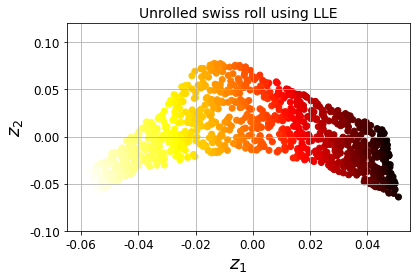

In [ ]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

save_fig("lle_unrolling_plot")
plt.show()